In [1]:
import os
import math
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 96

from sklearn.utils import Bunch
import scipy.stats

import seldon.ambiguity.posterior as posterior
from seldon.inference import BayesianInference, Posterior
from seldon.utils.binning import bin_values

In [2]:
def out_path(*parts) -> Path:
    p = Path("out", *parts)
    p.parent.mkdir(parents=True, exist_ok=True)
    return p

In [3]:
def to_filename(ns: np.ndarray, file_extension: str = "pdf") -> str:
    if len(ns.shape) > 1:
        ns, *_ = ns
    ns = ns.tolist()
    return f"example_{'-'.join(map(str, ns))}.{file_extension}"

In [4]:
def simulation_plot(
    posterior_object: Posterior,
    ax: mpl.axes.Axes,
    sample_size: int = 100_000,
    simulation_size: int = 100,
    bins: int = 256
):

    amb_values = list()
    
    try:
        ambs_grid = np.linspace(0, 1, bins)
        ambs_left = ambs_grid[:-1]
        ambs_right = ambs_grid[1:]
        grid_values = (ambs_left + ambs_right) / 2
        density_values = np.array(posterior_object.pdf(grid_values))
        ax.plot(grid_values, density_values, color="red")
    except NotImplementedError:
        
        bins_results = list()
        
        for _ in range(simulation_size):
            amb = posterior_object.sample(repeats=sample_size)
            bins_results.append(bin_values(amb, bins=bins))
            amb_values.append(amb)
    
        def to_densities(bin_res):
            return (
                1 / bin_res.bin_width * bin_res.counts / bin_res.counts.sum()
            )
        
        all_densities = np.vstack([to_densities(bins_res) for bins_res in bins_results])
        
        q25, q50, q75 = np.quantile(all_densities, q=[0.25, 0.5, 0.75], axis=0)

        grid_values = bins_results[0].bin_centers
        density_values = q50
        
        ax.plot(grid_values, q50, color="red")
        ax.fill_between(grid_values, q25, q75, color="red", alpha=0.3)
        
    xticks = np.linspace(0, 1, 21)
    ax.set_xlim(0, 1+1e-2)
    ax.set_xticks(xticks[::2])
    ax.set_xticks(xticks[1::2], minor=True)
    ax.grid(axis="x", which="major", linewidth=1)
    ax.grid(axis="x", which="minor", linewidth=1)
    ax.grid(axis="y")
    ax.set_xlabel("value")
    ax.set_ylabel("density")

    if isinstance(posterior_object, posterior.AmbiguityPosterior):
        ax.set_title("Old Ambiguity Measure")
    if isinstance(posterior_object, posterior.NewAmbiguityPosterior):
        ax.set_title("New Ambiguity Measure")
    if isinstance(posterior_object, posterior.ModifiedNewAmbiguityPosterior):
        ax.set_title("New Ambiguity Measure (Modified)")
    
    return ax, Bunch(
        samples=None if not amb_values else np.vstack(amb_values),
        density_values=density_values,
        grid_values=grid_values
    )

In [5]:
def annotated_simulation_plot(posterior_object: Posterior, ax: mpl.axes.Axes, **kwargs):
    
    ax, res = simulation_plot(posterior_object=posterior_object, ax=ax, **kwargs)

    grid_values = res.grid_values
    density_values = res.density_values
    
    mu = posterior_object.mean()
    sigma = posterior_object.std()
    lower, upper = np.clip(mu + np.array([-1, 1]) * sigma, 0, 1)
    idx_lower, idx_mean, idx_upper = (
        np.abs(grid_values.reshape(1, -1) - np.array([lower, mu, upper]).reshape(-1, 1))
        .argmin(axis=-1)
    )
    grid_indices_selected = np.arange(idx_lower, idx_upper + 1)
    density_values_selected = density_values[grid_indices_selected]

    predicate = (
        "exact" if any([
            isinstance(posterior_object, cls)
            for cls in [posterior.NewAmbiguityPosterior, posterior.ModifiedNewAmbiguityPosterior]
        ])
        else "approx."
    )
    
    ax.fill_between(
        grid_values[grid_indices_selected],
        np.zeros_like(density_values_selected),
        density_values_selected,
        alpha=0.3,
        label=f"{predicate} std"
    )
    ax.vlines(
        x=grid_values[idx_mean],
        ymin=0,
        ymax=density_values[idx_mean],
        color="black",
        linestyle="--",
        label=f"{predicate} mean"
    )
    ax.legend()

    return ax, res

In [6]:
#ns = np.array([10, 1, 1])
#ns = np.array([5, 0, 0])
#ns = np.array([10, 0, 0])
ns = np.array([30, 0, 0])

#ns = np.array([5, 5, 5])
#ns = np.array([3, 1, 3])

In [7]:
# Choice of prior
beta: float = 1

kwargs = dict(
    sample_size=100_000,
    simulation_size=100
)

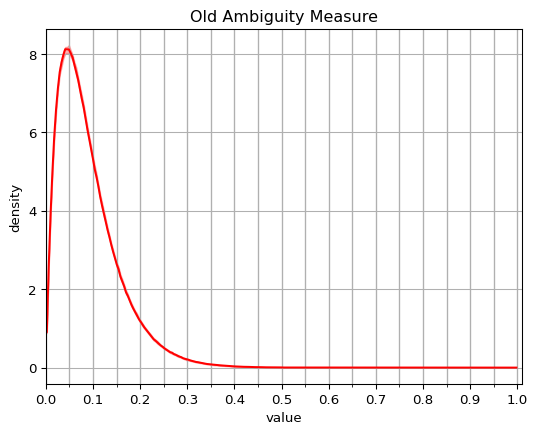

In [8]:
inference_object = (
    BayesianInference
    .specify(posterior.AmbiguityPosterior)
)(beta=beta).fit(ns)

fig, ax = plt.subplots()
_, res = simulation_plot(inference_object.posterior, ax=ax, **kwargs)
fig.savefig(out_path("inference", "old", to_filename(ns)), bbox_inches="tight")

plt.show()

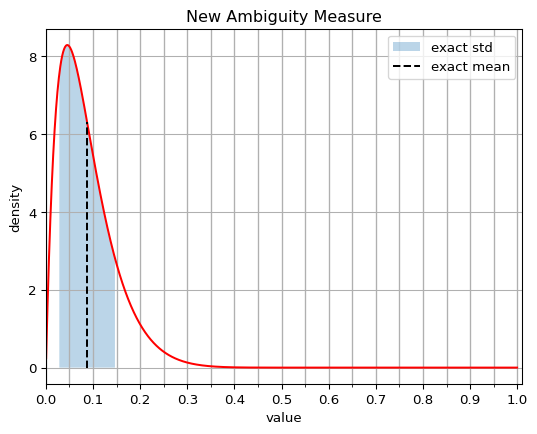

In [9]:
inference_object = (
    BayesianInference
    .specify(posterior.NewAmbiguityPosterior)
)(beta=beta).fit(ns)

fig, ax = plt.subplots()
_, res = annotated_simulation_plot(inference_object.posterior, ax=ax, bins=1001, **kwargs)
fig.savefig(out_path("inference", "new", to_filename(ns)), bbox_inches="tight")
plt.show()

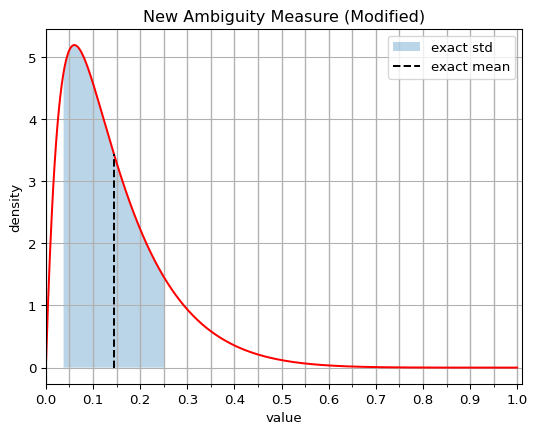

In [10]:
inference_object = (
    BayesianInference
    .specify(posterior.ModifiedNewAmbiguityPosterior)
)(beta=beta).fit(ns)

fig, ax = plt.subplots()
_, res = annotated_simulation_plot(inference_object.posterior, ax=ax, bins=1001, **kwargs)
fig.savefig(out_path("inference", "modified", to_filename(ns)), bbox_inches="tight")
plt.show()

**Display as grid for paper**

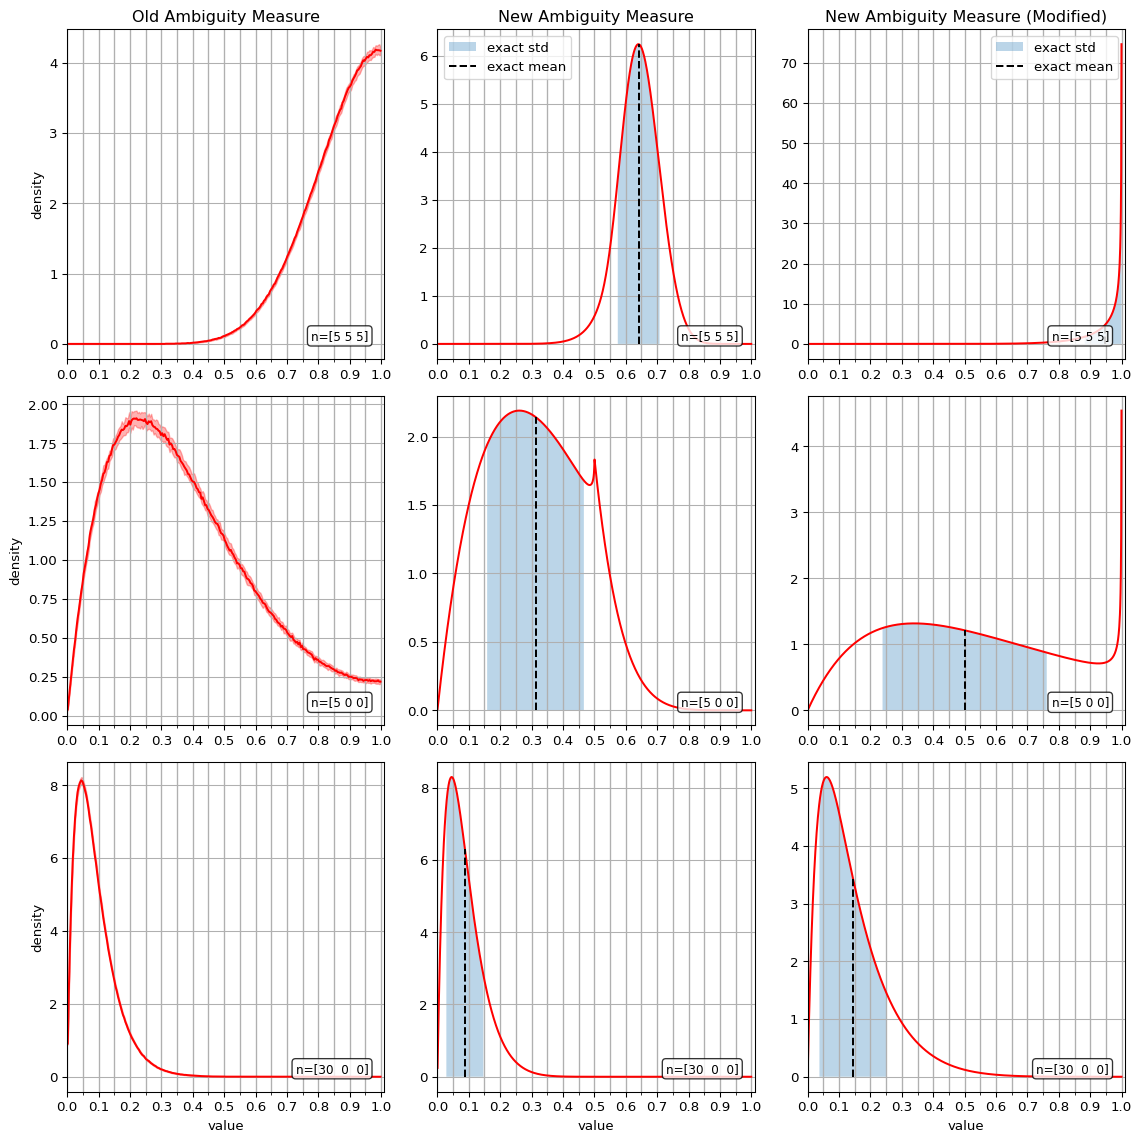

In [11]:
n_vectors = [
    np.array([5, 5, 5]),
    np.array([5, 0, 0]), 
    np.array([30, 0, 0])
]

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for row_idx, ns in enumerate(n_vectors):
    io_old = (BayesianInference.specify(posterior.AmbiguityPosterior))(beta=beta).fit(ns)
    ax = axs[row_idx, 0]
    simulation_plot(io_old.posterior, ax=ax, **kwargs)
    
    io_new = (BayesianInference.specify(posterior.NewAmbiguityPosterior))(beta=beta).fit(ns)
    ax = axs[row_idx, 1]
    annotated_simulation_plot(io_new.posterior, ax=ax, bins=1001, **kwargs)
    
    io_modified = (BayesianInference.specify(posterior.ModifiedNewAmbiguityPosterior))(beta=beta).fit(ns)
    ax = axs[row_idx, 2] 
    annotated_simulation_plot(io_modified.posterior, ax=ax, bins=1001, **kwargs)

for row in range(3):
    for col in range(3):
        ax = axs[row, col]
        
        # Y-label only on first column
        if col > 0:
            ax.set_ylabel('')
            
        # X-label on last row
        if row < 2:
            ax.set_xlabel('')
            
        # Title only in first row
        if row > 0:
            ax.set_title('')
            
        # Legend only in first row
        if row > 0 and ax.get_legend():
            ax.get_legend().remove()
        
        # Display observation counts as additional text
        n_text = f"n={n_vectors[row]}"
        ax.text(0.95, 0.05, n_text, transform=ax.transAxes, 
                ha='right', va='bottom', fontsize=9, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
fig.savefig(out_path("inference", "all_dists.pdf"), bbox_inches="tight")
plt.show()